In [1]:
#import thinkplot
#import thinkstats2
import pandas as pd
import numpy as np
import math
import scipy.stats as ss
#import thinkplot
#import thinkstats2
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

##Seaborn for fancy plots. 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (15,5)

# Assignment 3 - Basic Predictions and Regression

## Questions

<b>Note:</b> There was a little extra stuff at the bottom that I deleted. Everything beyond "Examine Colinierity" is random stuff, I was just using the notebook to process some data. It shoudl not impact any of the questiosn or anything. 

### Part 1 - Election Prediction

Suppose you are looking at an election in a fictional province. There are 7 total elctoral districts, and the winner in each district is determined by a first-past-the-post system (what we have in Canada - the most votes wins, regardless of share). There are two parties - the Purples and the Yellows. Whoever controls the most seats will be the ruling party - so in our 2 party scenario, the party who wins 4 or more of the districts will govern. There is an election every year, they love voting. 

Recent polling indicating the expected vote share in each district is shown in the "dist_polls" table below. These values are a composite of several polls that the experts have combined and weighted. The "Purple" values show the expected vote share of the Purple party, along with the variance of that expectation and the number of polls that were combined to get that result.  

As well, research has shown that the vote distribution is impacted by voter turnout. In general, the more people vote, the more the vote split shifts towards the Yellow party. We have data on past elections and the results, we expect that the turnout will be in line with the past elections - or more specifically, we have no reason to expect it to differ. This impact is measured in the table in code below - that table shows the voter turnout, in a percentage, as well as the change in the Yellow party's vote share (also in percentage) as compared to the polling averages. For example, if one row showed "52" and ".8", that would mean that voter turnout was 52%, and the Yellow party got .8% higher of a vote share than the polling showed. 

<b>What is the probability that the Purple Party controls the government after the election?</b>

<b>Note:</b> the errors and confidence intervals are not totally trivial. As part of the written answer, offer an evaluation of your confidence in the prediction, and why you think that. This is not a question with one specific error, your estimation will have some expected errors, somewhere. You may not have the tools to calculate it all the way through, that's fine. 

### Question 1 - Your Answer in English

Please fill in (and extend if required) the list here to explain what you did. There are multiple reasonable things you could do to approach this, so please note what you did here. For most people I assume this will be about 3-5 statements - you don't need to explain the internals of things we covered (e.g. if there's a hypothesis test, you don't need to explain how that works), just how you structured your approach to the problem. 

<ul> <li>I averaged the polls for each district and estimated the uncertainty.</li> <li>I simulated Purple’s vote share in each district using these averages and variations.</li> <li>I accounted for turnout effects by adjusting for historical Yellow over/under-performance.</li> <li>I ran many simulations, counted Purple seat wins, and estimated the chance of forming government.</li> <li><b>Error/accuracy:</b> It’s an approximation; assumptions like independent districts and small historical samples limit precision.</li> </ul>

## Start Your Work

### Part 1 - Election

##### Setup Poll Data

The dataframe "dist_polls" contains all of the polls for each seat. Each value is expressed as expected vote share (as a ratio) for the <b>Purple</b> party. The Yellow party can be safely assumed to get the rest of the votes. 

In [2]:
# Please don't edit this part. 
# Setup polling data. 
districts = [1,2,3,4,5,6,7]
dist_polls = pd.DataFrame(districts, columns=["District"])

dist_polls["Poll_1"] = [.55, .49, .51, .6, .41, .46, .54]
dist_polls["Poll_2"] = [.53, .51, .51, .62, .44, .48, .53]
dist_polls["Poll_3"] = [.51, .49, .53, .61, .42, .46, .52]
dist_polls["Poll_4"] = [.47, .48, .51, .54, .45, .45, .51]
dist_polls["Poll_5"] = [.61, .52, .49, .73, .44, .51, .53]
dist_polls["Poll_6"] = [.54, .45, .51, .61, .47, .52, .52]
dist_polls["Poll_7"] = [.55, .47, .5, .56, .47, .46, .56]
dist_polls["Poll_8"] = [.53, .49, .51, .55, .43, .49, .55]
dist_polls["Poll_9"] = [.57, .39, .52, .57, .53, .43, .53]


dist_polls.head(7)

,District,Poll_1,Poll_2,Poll_3,Poll_4,Poll_5,Poll_6,Poll_7,Poll_8,Poll_9
0,1,0.55,0.53,0.51,0.47,0.61,0.54,0.55,0.53,0.57
1,2,0.49,0.51,0.49,0.48,0.52,0.45,0.47,0.49,0.39
2,3,0.51,0.51,0.53,0.51,0.49,0.51,0.50,0.51,0.52
3,4,0.60,0.62,0.61,0.54,0.73,0.61,0.56,0.55,0.57
4,5,0.41,0.44,0.42,0.45,0.44,0.47,0.47,0.43,0.53
5,6,0.46,0.48,0.46,0.45,0.51,0.52,0.46,0.49,0.43
6,7,0.54,0.53,0.52,0.51,0.53,0.52,0.56,0.55,0.53


### Polling Distribution 

Do whatever you need to do to translate the polling data into some form of model. 

In [3]:
poll_cols = [c for c in dist_polls.columns if c.startswith("Poll")]
means = dist_polls[poll_cols].mean(axis=1).values
stds = dist_polls[poll_cols].std(axis=1).values

n_sims = 200000
wins = 0
rng = np.random.default_rng()

for _ in range(n_sims):
    draws = rng.normal(means, stds)
    purple_wins = (draws > 0.5).sum()
    if purple_wins >= 4:
        wins += 1

probability = wins / n_sims
probability

0.79105

##### Setup Turnout Data

The dataframe "past_vte_table" shows the voter turnout, along with the impact on the votes counted for the <b>Yellow party</b>, all expressed as percentages. For example, if in one row the turnout is .45 and the Yellow_improvement is -.04, that means that 45% of the populace turned out to vote, and the Yellow party got 4% fewer votes than polling indicated. 

In [4]:
# Please don't edit this part. 
# Setup vote data. 
voter_turnout_history = [.53, .51, .48, .55, .54, .59, .49, .57, .56]
past_vote_table = pd.DataFrame(voter_turnout_history, columns=["voter_turn_percentage"])
past_vote_table["Yellow_improvement"] = [.012, .023, -.017, .031, .030, -.004, -.03, .042, .029]
past_vote_table["year"] = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
past_vote_table.head()

,voter_turn_percentage,Yellow_improvement,year
0,0.53,0.012,2013
1,0.51,0.023,2014
2,0.48,-0.017,2015
3,0.55,0.031,2016
4,0.54,0.030,2017


### Run Simulations

Run whatever simulations you need. 

In [5]:
turnout_mean = np.mean(voter_turnout_history)
turnout_std = np.std(voter_turnout_history)

yellow_mean = np.mean(past_vote_table["Yellow_improvement"])
yellow_std = np.std(past_vote_table["Yellow_improvement"])

# Simulation: draw turnout + Yellow adjustment
n_sims = 200000
rng = np.random.default_rng()

wins = 0

for _ in range(n_sims):

    # turnout + yellow shift
    turnout_sample = rng.normal(turnout_mean, turnout_std)
    yellow_shift   = rng.normal(yellow_mean, yellow_std)

    # draw underlying district vote share
    purple_draws = rng.normal(means, stds)

    # adjust for Yellow over/under-performance
    adj_purple = purple_draws - yellow_shift

    # count districts Purple wins
    purple_wins = (adj_purple > 0.5).sum()

    if purple_wins >= 4:
        wins += 1

probability = wins / n_sims
probability

0.450855

### Part 2 - Regression

<b>Use the data provided to try to predict the wage. </b>

The data is from FIFA rankings for players. You don't need to know anything about soccer or video games for this, so if these values are meaningless to you, just treat them as numbers and you'll be fine. All of the features are rankings are evaluations of how good different soccar players are at different skills.

#### Answer in English

Please fill in (and extend if required) the list here to explain what you did. There are multiple reasonable things you could do to approach this, so please note what you did here. For most people I assume this will be about 3-5 statements - you don't need to explain the internals of things we covered (e.g. if there's a hypothesis test, you don't need to explain how that works), just how you structured your approach to the problem. 

<ul>
<li>
<li>
<li>
</ul>

In [6]:
df = pd.read_csv("data/players_20_2.csv")
df.head()

,wage_eur,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,...,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle
0,565000,88,95,70,92,88,97,93,94,92,...,94,48,40,94,94,75,96,33,37,26
1,405000,84,94,89,83,87,89,81,76,77,...,93,63,29,95,82,85,95,28,32,24
2,290000,87,87,62,87,87,96,88,87,81,...,84,51,36,87,90,90,94,27,26,29
3,125000,13,11,15,43,13,12,13,14,40,...,12,34,19,11,65,11,68,27,12,18
4,470000,81,84,61,89,83,95,83,79,83,...,80,54,41,87,89,88,91,34,27,22


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
wage_eur,18278.0,9456.942773,21351.714095,0.0,1000.0,3000.0,8000.0,565000.0
attacking_crossing,18278.0,49.718405,18.325403,5.0,38.0,54.0,64.0,93.0
attacking_finishing,18278.0,45.590218,19.594609,2.0,30.0,49.0,62.0,95.0
attacking_heading_accuracy,18278.0,52.221468,17.428429,5.0,44.0,56.0,64.0,93.0
attacking_short_passing,18278.0,58.748003,14.679653,7.0,54.0,62.0,68.0,92.0
attacking_volleys,18278.0,42.809388,17.701815,3.0,30.0,44.0,56.0,90.0
skill_dribbling,18278.0,55.596509,18.929118,4.0,50.0,61.0,68.0,97.0
skill_curve,18278.0,47.325692,18.422991,6.0,34.0,49.0,62.0,94.0
skill_fk_accuracy,18278.0,42.708885,17.433612,4.0,31.0,41.0,56.0,94.0
skill_long_passing,18278.0,52.768848,15.246454,8.0,43.0,56.0,64.0,92.0


#### Clean some data

In [8]:
df["log_wage"] = np.log1p(df["wage_eur"])
upper = df["wage_eur"].quantile(0.99)
df = df[df["wage_eur"] <= upper]

y = df["log_wage"]
X = df.drop(columns=["wage_eur", "log_wage"])

In [9]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
r2 = lr.score(X_test, y_test)

print("RMSE:", rmse)
print("R-squared:", r2)

coef_table = pd.DataFrame({
    "feature": X.columns,
    "coef": lr.coef_
}).sort_values(by="coef", ascending=False)

coef_table.head(10)

RMSE: 1.3450181965287442
R-squared: 0.23516036668884222


,feature,coef
13,movement_reactions,0.057047
15,power_shot_power,0.019000
25,mentality_composure,0.015223
3,attacking_short_passing,0.011881
9,skill_ball_control,0.006978
23,mentality_vision,0.006784
27,defending_standing_tackle,0.006212
6,skill_curve,0.005810
5,skill_dribbling,0.004753
16,power_jumping,0.004232


#### Examine Colinerarity

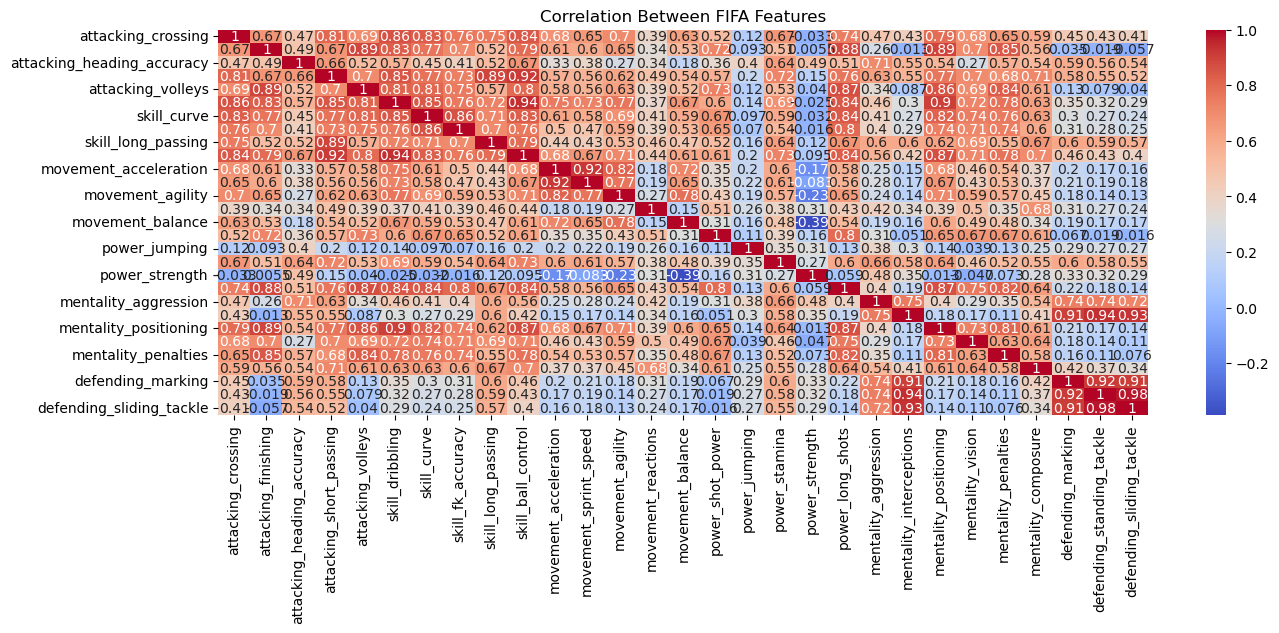

In [10]:
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between FIFA Features")
plt.show()

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

vif_df = calc_vif(X)
print(vif_df)

                     variables         VIF
0           attacking_crossing   51.742136
1          attacking_finishing   73.465797
2   attacking_heading_accuracy   51.283406
3      attacking_short_passing  225.452413
4            attacking_volleys   48.155552
5              skill_dribbling  163.432904
6                  skill_curve   54.311695
7            skill_fk_accuracy   34.806550
8           skill_long_passing   95.282993
9           skill_ball_control  255.926285
10       movement_acceleration  175.921210
11       movement_sprint_speed  148.858726
12            movement_agility   96.116481
13          movement_reactions  101.955152
14            movement_balance   63.697885
15            power_shot_power   76.832457
16               power_jumping   46.613618
17               power_stamina   60.249877
18              power_strength   53.655521
19            power_long_shots   65.744109
20        mentality_aggression   43.245097
21     mentality_interceptions   71.611234
22       me